In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.9.2
Running on TPU  ['10.37.210.50:8470']


In [ ]:
#proof of concept ran on older normalized data set
rating_df = pd.read_csv('train_streamID.csv')
rating_df = rating_df.rename(columns={'UserID':'u_id','StreamID':'s_id','Rating':'rate'})
rating_df.head()

,u_id,s_id,rate
0,1,33846768288,2.014098
1,1,33887624992,1.000000
2,1,33890145056,2.014098
3,1,33903958784,2.014098
4,1,33929318864,9.993371


In [ ]:
# model requires a random seed
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['u_id', 's_id']].values
y = rating_df["rate"]

In [ ]:
# this says test and train but is really train and validation
#lifted this from: https://www.kaggle.com/code/chaitanya99/recommendation-system-cf-anime
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 1481841
> Test set ratings: 10000


In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
#from: https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/NeuMF.py#L158
in_u_dim = len(rating_df["u_id"].unique())
in_s_dim = len(rating_df["s_id"].unique())
 
latent_out_dim = 8 #embedding size
# Embedding(input_dim = num_items
# num_users, num_items = train.shape
# output_dim = mf_dim
# mf = 10

In [ ]:
# Embedding layers
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def GMFact():
    
    user = Input(name = 'u_in', shape = [1])
    user_embedding = Embedding(name = 'u_emb',
                       input_dim = in_u_dim, 
                       output_dim = latent_out_dim)(user)
    
    stream = Input(name = 's_in', shape = [1])
    stream_embedding = Embedding(name = 's_emb',
                       input_dim = in_s_dim, 
                       output_dim = latent_out_dim)(stream)
    
    x = tf.keras.layers.Concatenate()([user_embedding, stream_embedding])
    x = Flatten()(x)

    #from: https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/NeuMF.py#L65
    # get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    # MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0]/2, name = "mlp_embedding_user",
    #                               init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)
    # MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0]/2, name = 'mlp_embedding_item',
    #                               init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)   
    # for idx in xrange(1, num_layer):
    #     layer = Dense(layers[idx], W_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
    #     mlp_vector = layer(mlp_vector)
    #skipping regularization due to compatibility issues

    x = keras.layers.Dense(8, activation='relu')(x) 
    x = keras.layers.Dense(4, activation='relu')(x) 

    x = Dense(1, kernel_initializer='lecun_uniform')(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, stream], outputs=x)
    model.compile(
      optimizer='sgd',
      loss='mse',
      metrics=[tf.keras.metrics.RootMeanSquaredError()])
      #https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError
    
    return model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = GMFact()
model.summary()
#https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=hJl3vNtJOB-x



Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u_in (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 s_in (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 u_emb (Embedding)              (None, 1, 8)         775368      ['u_in[0][0]']                   
                                                                                                  
 s_emb (Embedding)              (None, 1, 8)         3586200     ['s_in[0][0]']                   
                                                                                           

In [ ]:
# Model training
batch_size = 10000
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test)
)

model.save_weights('gmf.h5')

Epoch 1/20
149/149 [==============================] - 8s 33ms/step - loss: 14.7794 - root_mean_squared_error: 3.8444 - val_loss: 13.9239 - val_root_mean_squared_error: 3.7315
Epoch 2/20
149/149 [==============================] - 4s 24ms/step - loss: 13.7364 - root_mean_squared_error: 3.7063 - val_loss: 13.6085 - val_root_mean_squared_error: 3.6890
Epoch 3/20
149/149 [==============================] - 4s 24ms/step - loss: 13.5856 - root_mean_squared_error: 3.6859 - val_loss: 13.5418 - val_root_mean_squared_error: 3.6799
Epoch 4/20
149/149 [==============================] - 4s 23ms/step - loss: 13.5448 - root_mean_squared_error: 3.6803 - val_loss: 13.5172 - val_root_mean_squared_error: 3.6766
Epoch 5/20
149/149 [==============================] - 4s 23ms/step - loss: 13.5275 - root_mean_squared_error: 3.6780 - val_loss: 13.5051 - val_root_mean_squared_error: 3.6749
Epoch 6/20
149/149 [==============================] - 4s 23ms/step - loss: 13.5184 - root_mean_squared_error: 3.6767 - val_lo

In [ ]:
model.predict_on_batch([rating_df.iloc[:,0].to_numpy(), rating_df.iloc[:,1].to_numpy()])


array([[0.99292076],
       [0.99294746],
       [0.99313176],
       ...,
       [0.99240553],
       [0.9926664 ],
       [0.9919225 ]], dtype=float32)

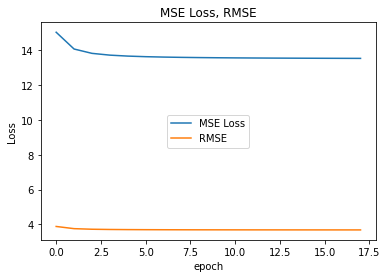

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["root_mean_squared_error"][0:-2])
plt.title("MSE Loss, RMSE")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["MSE Loss", "RMSE"], loc="center")
plt.show()

In [ ]:
final_RMSE = (history.history['root_mean_squared_error'])[-1]
final_RMSE

3.678248643875122

In [ ]:
#https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_actual, y_predicted, squared=False)